# Triplet Loss

In [1]:
from pathlib import Path

METRICS_FILEPATH = "metrics.json"

MODEL_DIR = "models"
FIG_DIR = "figures"

# Create output directories if not exist
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

## Intuition

With Contrastive Loss, our model seemed to be struggling to push apart the embeddings far enough to allow for reliable discrimination of hard pairings.

A solution to this problem might be [Triplet Loss](https://lilianweng.github.io/posts/2021-05-31-contrastive/#triplet-loss).

With Triplet Loss we extend the comparison to include a reference (anchor) $x_i^a$ a similar (positive) $x_i^p$ **and** a dissimilar (negative) sample $x_i^n$.

If we assume our Neural Network to be a function $f$, Triplet Loss for a single triplet can be formulated as:

$$L_{triplet}(x_i^a, x_i^p, x_i^n; f; m) = max(0, ||f(x_i^a) - f(x_i^p) ||^2_2 - ||f(x_i^a) - f(x_i^n) ||^2_2 + m)$$

where $m$ again denotes the desired distance for the dissimilar sample.

## Hard Triplet Mining

As our Contrastive Loss model was struggling on hard comparisons, we'll also try to be more intent with the comparisons chosen for the model training.

We could define hard triplets as triplets, where the model's predicted distance between the anchor and the positive is larger than the distance between the anchor and the negative plus the margin $m$.

In practice, selecting only such triplets seems to cause model instabilities, especially in the early stages of training. (We can observe this when swapping the loss function for `TripletHardLoss`.)

Therefore we'll instead be using semi-hard triplets, where the distance between the negative and the anchor is within the margin $m$ and greater than, but close to, the distance between the anchor and the positive.

## One-Shot Classification using Triplet Loss

We'll use the [`TripletSemiHardLoss` function from the TensorFlow Addons library](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss) for Triplet Loss with semi-hard negative mining.

Since this implementation handles the formation of triplets entirely as part of the loss function, we don't need to structure our model as as Siamese Neural Network.

We can therefore simply load our dataset as categorical data:

In [2]:
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)
x_train = categorical_dataset.x_train
y_train = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

As always we'll optimize the model architecture with Keras Tuner.

The model will simply be an encoder with L2 Normalization as the last layer as specified in the [TFA documentation](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss):

In [3]:
from tensorflow_addons.losses import TripletSemiHardLoss
from core.util import new_SNN_builder

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="encoder_l2",
    loss=TripletSemiHardLoss(
        margin=1.0,
        distance_metric="angular"
    )
)

/Users/moritz/Documents/Hochschule Augsburg/Semester 2 - Master/Data Science/project/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 200
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42
VAL_SPLIT = 0.2

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "triplet_loss"

In [5]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Reloading Tuner from tuner/triplet_loss/tuner0.json
Search space summary
Default search space size: 7
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


We'll use the same callbacks as for the Contrastive Loss training.

In [6]:
from core.util import new_default_callbacks

from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    lr_reduce_factor=0.2,
    lr_reduce_patience=10,
    early_stopping_start=10,
    early_stopping_patience=20,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

Loading history from JSON tuner/triplet_loss/history.json


In [7]:
tuner.search(
    x_train, 
    y_train,
    validation_split=VAL_SPLIT,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

In [8]:
tuner.results_summary()

Results summary
Results in tuner/triplet_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0246 summary
Hyperparameters:
dense_count: 4
dense_base: 48
encoder_dropout: False
start_lr: 0.0007000000000000001
beta_1: 0.7
beta_2: 0.998
epsilon: 0.001
tuner/epochs: 200
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10158593952655792

Trial 0233 summary
Hyperparameters:
dense_count: 6
dense_base: 64
encoder_dropout: False
start_lr: 0.0007000000000000001
beta_1: 0.7999999999999999
beta_2: 0.992
epsilon: 0.008
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0226
Score: 0.13295254111289978

Trial 0232 summary
Hyperparameters:
dense_count: 10
dense_base: 40
encoder_dropout: False
start_lr: 0.0004
beta_1: 0.7
beta_2: 0.998
epsilon: 0.010000000000000002
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 0.14004473388195038

Trial 0206 summary
Hyperparameters:
d

Since we want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [9]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, siamese_snn = build_model(best_hyper_params, get_encoder=True)
siamese_snn.set_weights(best_weights)

siamese_snn.summary()
snn_encoder.summary()

Model: "encoder_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Input (InputLayer  [(None, 21, 3)]           0         
 )                                                               
                                                                 
 Layer_Norm (LayerNormaliza  (None, 21, 3)             6         
 tion)                                                           
                                                                 
 Flatten_Landmarks (Flatten  (None, 63)                0         
 )                                                               
                                                                 
 Dense_1 (Dense)             (None, 768)               49152     
                                                                 
 Dense_2 (Dense)             (None, 432)               332208    
                                                        

Let's save the best model and take a look at its training history:

In [10]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

siamese_snn.save(f"{MODEL_DIR}/triplet_loss.keras")

The model now takes even longer to converge and we can notice some significant spikes in both, training and validation loss.

This could, however, also simply be due to the training objective getting progressively harder, when we are selecting new semi-hard triplets for every mini-batch.

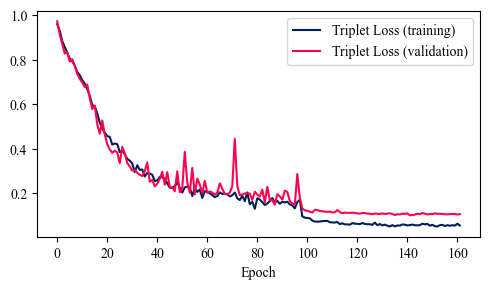

In [11]:
from core.viz import visualize_history

visualize_history(
    best_model_history,
    ["loss"],
    "Triplet Loss",
    f"{FIG_DIR}/triplet_loss_history.svg"
)

Our loss on new signs, seems significantly worse than with Contrastive Loss (at least in absolute numbers):

In [12]:
# And evaluate the model on test data
loss = siamese_snn.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.8102


Evaluating the model's 5-way One-Shot classification accuracy unfortunately shows the same trend:

In [13]:
from core.util import evaluate_n_way_accuracy


y_true, y_pred, mean_acc, min_acc, max_acc, std = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=1,
    iterations=10
)

print(
    f"Mean 5-way accuracy: {mean_acc}\n"
    f"Min 5-way accuracy: {min_acc}\n"
    f"Max 5-way accuracy: {max_acc}\n"
    f"5-way accuracy std.: {std}"
)

Mean 5-way accuracy: 0.6079746835443038
Min 5-way accuracy: 0.4936708860759494
Max 5-way accuracy: 0.6810126582278481
5-way accuracy std.: 0.06357795770277734


Looking at the confusion matrix, we can the the same struggle with the "u" and "v" classes with lots of additional confusions for other classes as well:

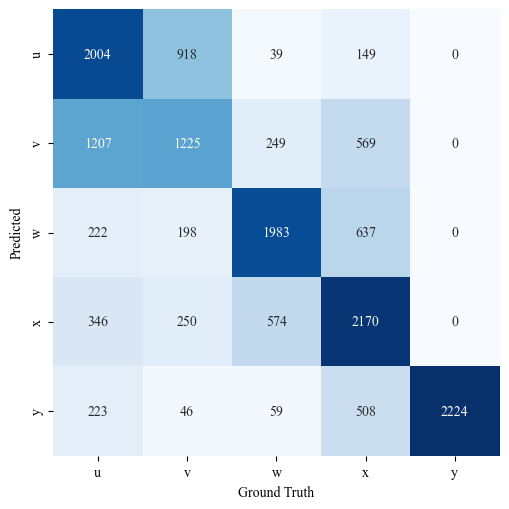

In [14]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/triplet_loss_conf_matrix.svg"
)

Using multiple support samples to form support prototypes increases the 5-way accuracy, however it's still lower than the Contrastive Loss model's accuracy without prototypes: 

In [15]:
from core.util import save_n_way_k_prototype_accuracy

save_n_way_k_prototype_accuracy(
    x_test,
    y_test,
    snn_encoder,
    METRICS_FILEPATH,
    "Triplet Loss"
)

Mean 5-way accuracy (k-prototype = 1): 0.6079746835443038, std: 0.06357795770277734
Mean 5-way accuracy (k-prototype = 3): 0.6540127388535031, std: 0.06878202362172792
Mean 5-way accuracy (k-prototype = 5): 0.7123076923076923, std: 0.034026085441419746
Mean 5-way accuracy (k-prototype = 10): 0.7336807817589577, std: 0.021970533124513386
Mean 5-way accuracy (k-prototype = 15): 0.730728476821192, std: 0.0103158317767527
Mean 5-way accuracy (k-prototype = 20): 0.7296969696969697, std: 0.009870317392902506
Mean 5-way accuracy (k-prototype = 50): 0.7295880149812735, std: 0.015340268014270589
Mean 5-way accuracy (k-prototype = 75): 0.7298347107438017, std: 0.00871851864983833
Mean 5-way accuracy (k-prototype = 100): 0.7354838709677419, std: 0.008191884255590405
Saved Triplet Loss metrics to metrics.json


Unsurprisingly, the confusion matrix looks better when using prototypes, but it still shows all the known problems:

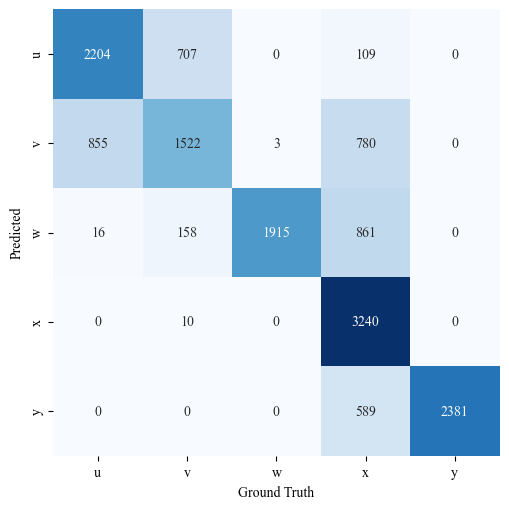

In [16]:
y_true, y_pred, _, _, _, _ = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=10,
    iterations=10
)

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/triplet_loss_conf_matrix_k10.svg"
)

Finally, we'll visualize the Triplet Loss model's embedding space:

In [17]:
# Get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 958us/step


In [18]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 0.001232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.130238
[t-SNE] KL divergence after 1000 iterations: 0.283937


Again, the confusion matrix is reflected in the model's embeddings:

We can again see a large overlap for "u" and "v" samples, with an additional overlapping are for all classes in the middle:

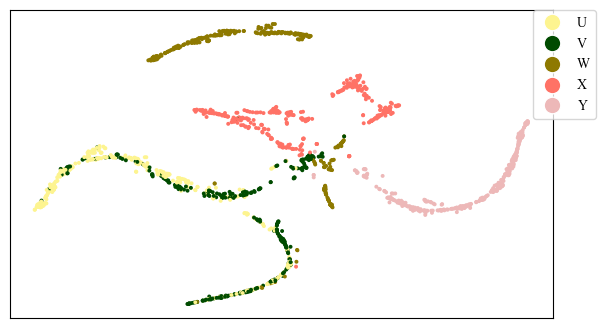

In [19]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map,
    f"{FIG_DIR}/triplet_loss_embeddings.svg"
)

It's difficult to tell if this subpar performance is due to Contrastive Loss itself or the tuner being unable to find a more optimal configuration, since we could observe lots of tuner trials showing no model convergence at all.

Additionally, when running classification, we won't be comparing against a single negative but multiple negative samples.
Maybe a loss function that takes this into account, such as [Multi-Class N-Pair Loss](./n_pair_loss.ipynb), might help improve our model's One-Shot classification performance?